In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu

In [20]:
DATA_PATH = "/kaggle/input/datasets/mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask/data science bowl 2018/stage1_train 2"

In [21]:
def create_binary_mask(mask_path):
    mask = cv2.imread(mask_path, 0)
    
    # Otsu thresholding for robustness
    thresh = threshold_otsu(mask)
    binary = mask > thresh
    
    # Remove small noise
    binary = binary.astype(np.uint8)
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return cleaned

In [22]:
def naive_watershed(binary):
    distance = ndi.distance_transform_edt(binary)
    labels = watershed(-distance, mask=binary)
    return labels

In [23]:
def marker_watershed(binary, min_dist=8):
    
    distance = ndi.distance_transform_edt(binary)
    
    # Find local maxima as markers
    coordinates = peak_local_max(
        distance,
        min_distance=min_dist,
        labels=binary
    )
    
    markers = np.zeros(distance.shape, dtype=int)
    
    for i, coord in enumerate(coordinates):
        markers[coord[0], coord[1]] = i + 1
    
    labels = watershed(-distance, markers, mask=binary)
    
    return labels


Image 1
Ground Truth Count: 9
Naive Watershed Count: 1
Marker Watershed Count: 1


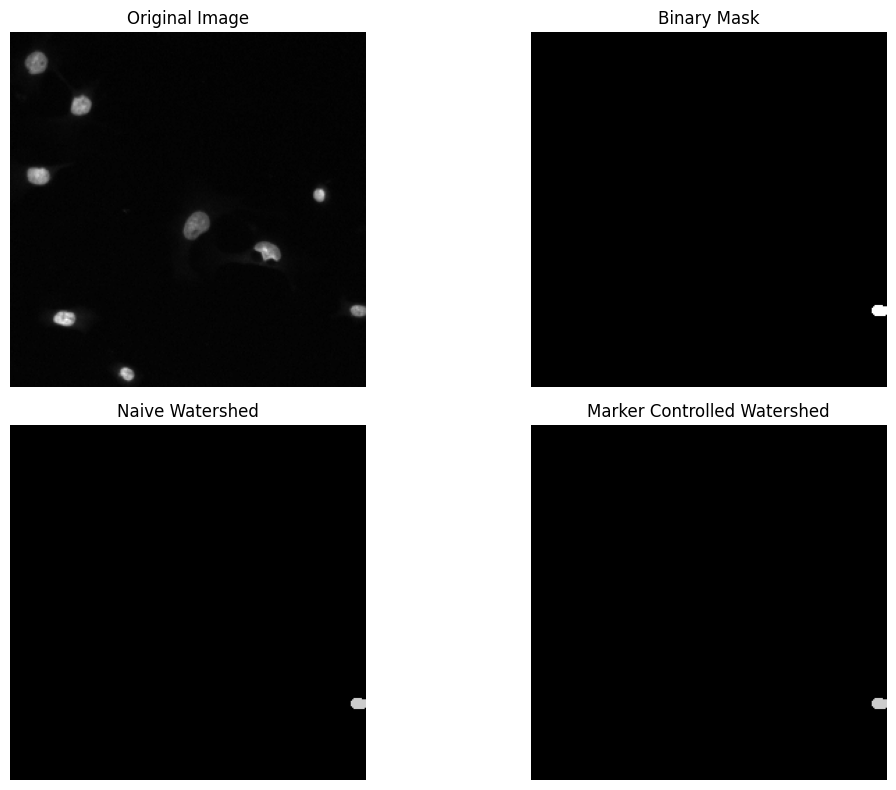


Image 2
Ground Truth Count: 23
Naive Watershed Count: 1
Marker Watershed Count: 1


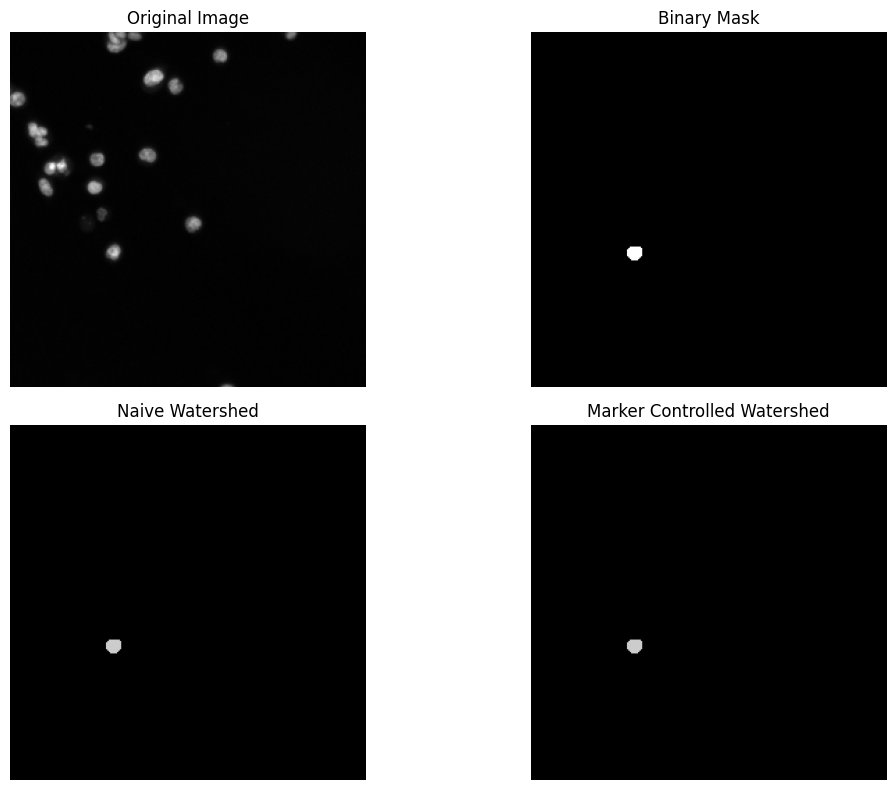


Image 3
Ground Truth Count: 9
Naive Watershed Count: 13
Marker Watershed Count: 9


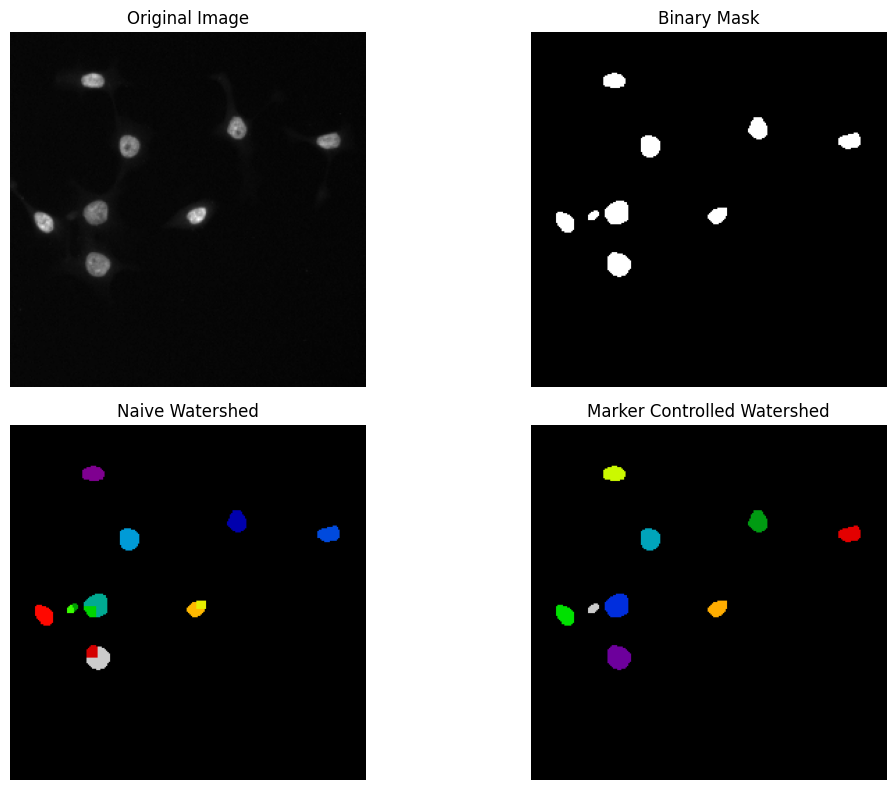


Image 4
Ground Truth Count: 4
Naive Watershed Count: 5
Marker Watershed Count: 3


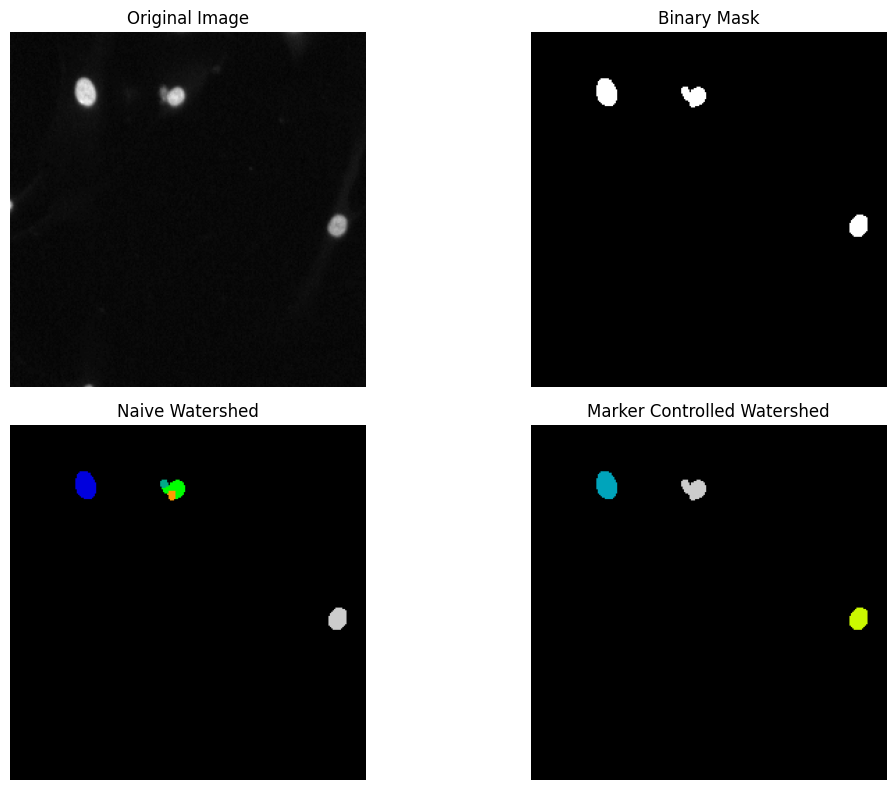


Image 5
Ground Truth Count: 12
Naive Watershed Count: 17
Marker Watershed Count: 12


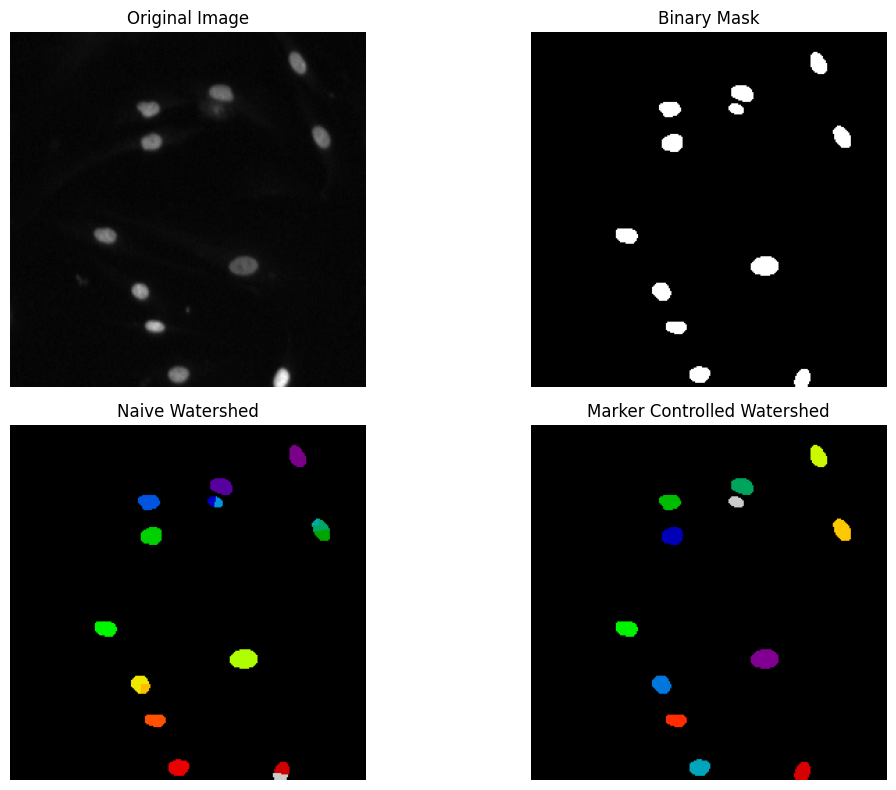


Image 6
Ground Truth Count: 20
Naive Watershed Count: 7
Marker Watershed Count: 1


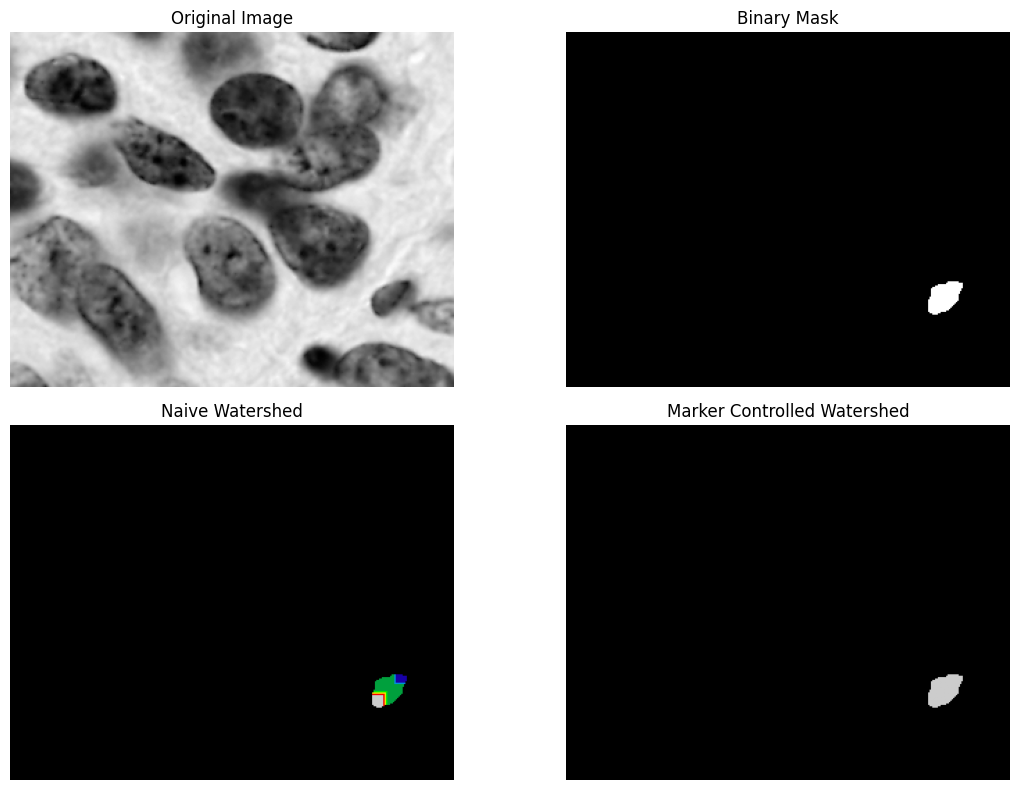


Image 7
Ground Truth Count: 37
Naive Watershed Count: 2
Marker Watershed Count: 1


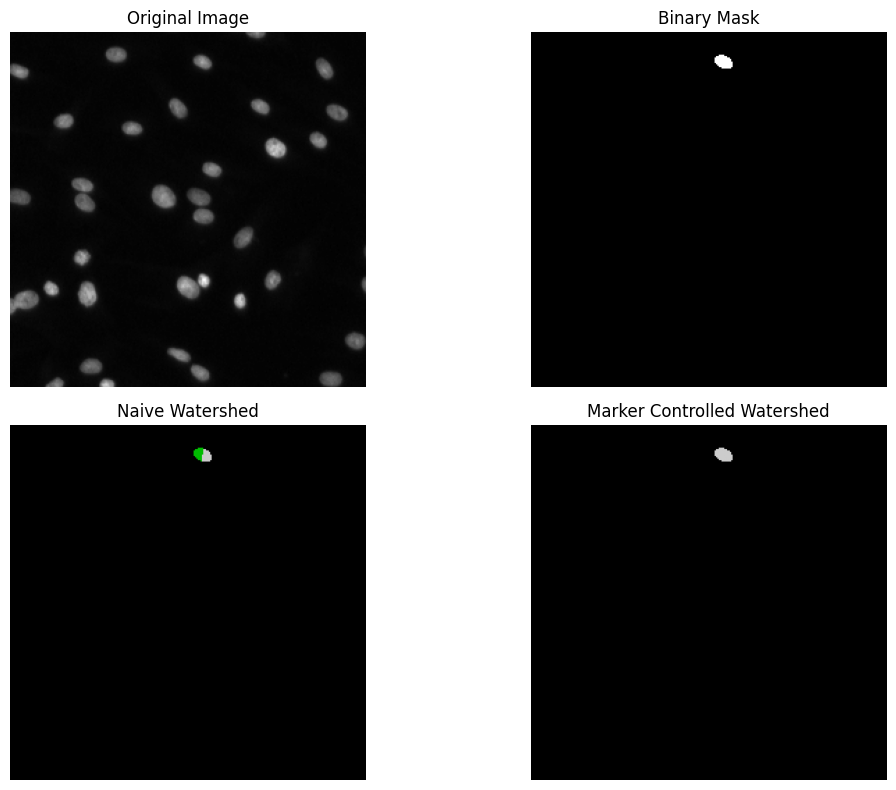


Image 8
Ground Truth Count: 83
Naive Watershed Count: 16
Marker Watershed Count: 1


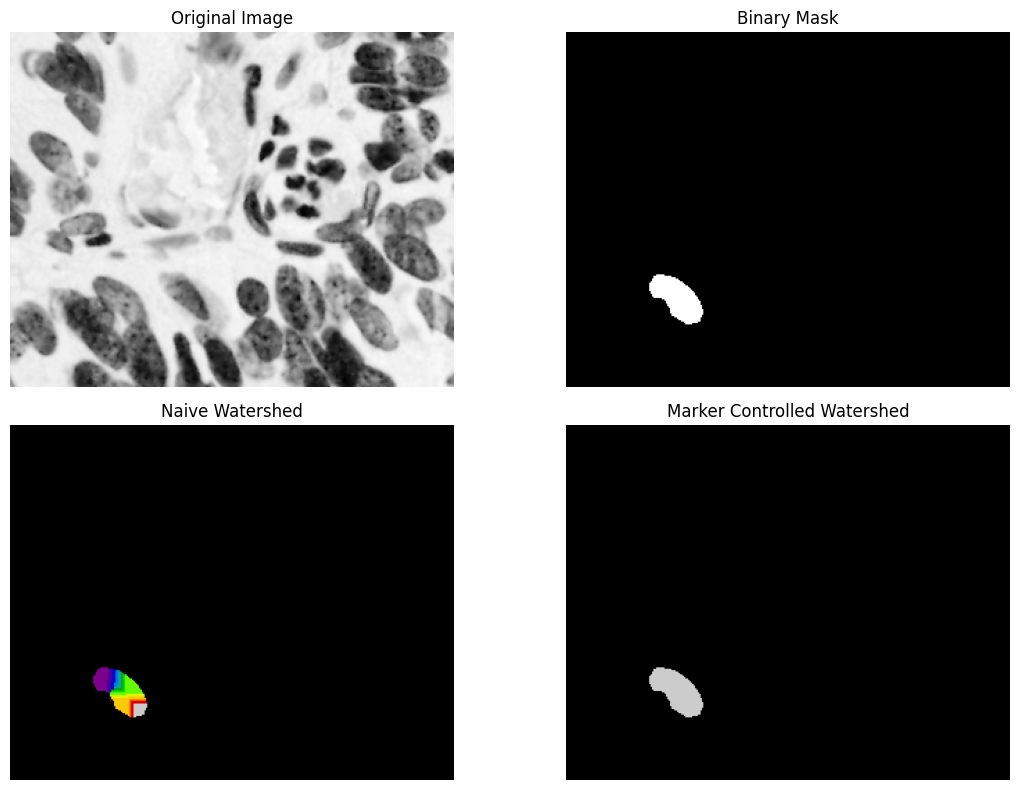


Image 9
Ground Truth Count: 20
Naive Watershed Count: 11
Marker Watershed Count: 2


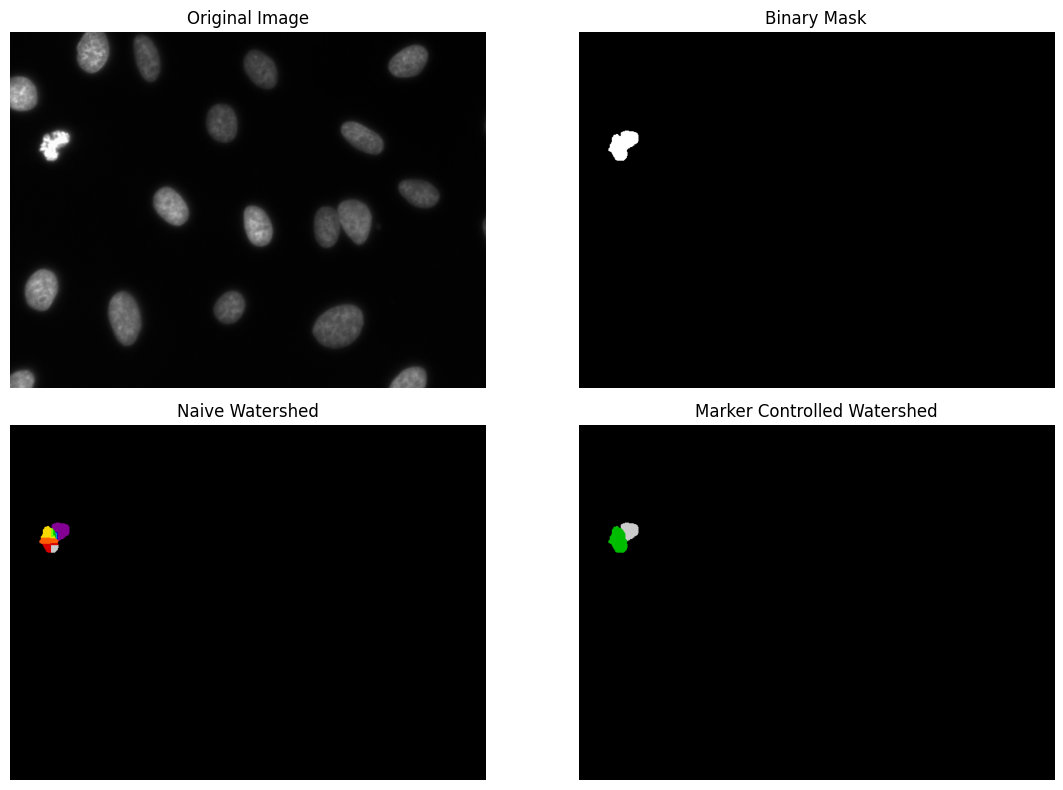


Image 10
Ground Truth Count: 2
Naive Watershed Count: 2
Marker Watershed Count: 1


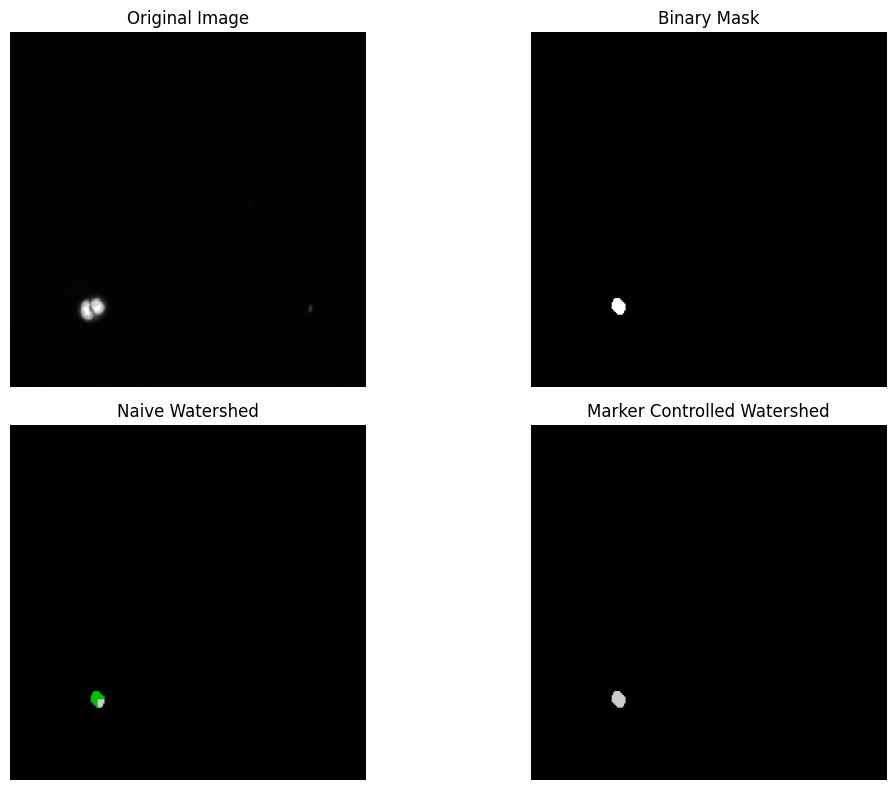

In [24]:
MAX_IMAGES = 10
count = 0

for folder in os.listdir(DATA_PATH):
    
    if count >= MAX_IMAGES:
        break
    
    sample_path = os.path.join(DATA_PATH, folder)
    
    image_path = os.path.join(sample_path, "images")
    mask_path = os.path.join(sample_path, "masks")
    
    image_file = os.listdir(image_path)[0]
    mask_files = sorted(os.listdir(mask_path))
    
    image = cv2.imread(os.path.join(image_path, image_file), 0)
    
    # Merge all masks (ground truth)
    merged_mask = np.zeros_like(image)
    
    for m in mask_files:
        m_img = cv2.imread(os.path.join(mask_path, m), 0)
        merged_mask = np.maximum(merged_mask, m_img)
    
    ground_truth_count = len(mask_files) - 1 #Since first mask image is combined mask
    
    binary = create_binary_mask(os.path.join(mask_path, mask_files[0]))
    
    # Apply Methods
    naive_labels = naive_watershed(binary)
    marker_labels = marker_watershed(binary, min_dist=8)
    
    print(f"\nImage {count+1}")
    print("Ground Truth Count:", ground_truth_count)
    print("Naive Watershed Count:", naive_labels.max())
    print("Marker Watershed Count:", marker_labels.max())
    
    plt.figure(figsize=(12,8))
    
    plt.subplot(2,2,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,2,2)
    plt.title("Binary Mask")
    plt.imshow(binary, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,2,3)
    plt.title("Naive Watershed")
    plt.imshow(naive_labels, cmap='nipy_spectral')
    plt.axis('off')
    
    plt.subplot(2,2,4)
    plt.title("Marker Controlled Watershed")
    plt.imshow(marker_labels, cmap='nipy_spectral')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    count += 1

In this assignment, I implemented both naive watershed and marker-controlled watershed to separate touching cell nuclei from the Data Science Bowl dataset. The process began with preprocessing and generating a clean binary mask, followed by computing the distance transform to highlight the central regions of each nucleus. In the naive watershed approach, segmentation was directly performed on the inverted distance map, which resulted in noticeable over-segmentation due to multiple local minima being treated as separate regions. To address this, I applied marker-controlled watershed by detecting reliable local maxima as markers and using them to guide region formation. This significantly reduced unnecessary splits and produced nuclei counts closer to the ground truth masks. By comparing the outputs, it is clear that marker-based watershed provides more stable and controlled segmentation, effectively minimizing over-segmentation while accurately separating touching nuclei.